# 🔋 **Extended Kalman Filter for Generating Open Circuit Voltage vs SoC Relationship**
***

### The notebook being divided into phases 📖
🧪 **Data Proceesing** 

📊 **Data Visualization** 

📉 **Data Fitting** 
***

#### 📚Library Imports

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

***
## 🧪Phase 1 - Data Processing
>   - Recieves open circuit voltage and current through bleeder resistor data from Measurement-to-Serial.ino
>   - Extended Kalman Filter is applied to the data to process SoC
>   - Open Circuit Voltage and SoC is stored in a CSV

#### 💾 Ardunio NANO connected to COM5

In [62]:
arduino_port = "COM5"
baud = 9600 
fileName="V_oc&SoC.csv"
ser = serial.Serial(arduino_port, baud)
file = open(fileName, "a")

#### 📲 Dual Polarization Model and EKF Parameters

In [3]:
del_t = 100       #in milliseconds(ms)
SoC = 1;
V_ct = 0.007;
V_df = 0.004;
tau_ct = 4;
tau_df = 100;
R_ct = 0.001;
R_df = 0.01;
R_0 = 0.2;
R_l = 2.2;
Charge = 1.082*3600;


x = np.array([[SoC],
              [V_ct],
              [V_df]]);

A = np.array([[1, 0, 0],
              [0, np.exp(-(del_t/1000)/tau_ct), 0],
              [0, 0, np.exp(-(del_t/1000)/tau_df)]]);
              
B = np.array([[-(del_t/1000)/Charge],
              [R_ct*(1-np.exp(-(del_t/1000)/tau_ct))],
              [R_df*(1-np.exp(-(del_t/1000)/tau_df))]]);

P = np.array([[1e-25, 0, 0],
              [0, 1e-23, 0],         
              [0, 0, 1e-23]]);

R = np.array([1e-7]);

Q = np.array([[1e-25, 0, 0],
              [0, 1e-23, 0],         
              [0, 0, 1e-23]]);

C = np.array([1, -1, -1]);

#### 🧮 **Extended Kalman Filter**
> - Data Estimation
> - Data Storage

[1] Algorithm based on Carlo Taborelli, Simona Onori. (2014)."[State of Charge Estimation
 Using Extended Kalman Filters for Battery Management System](https://ieeexplore.ieee.org/document/7056126)". 
 
 
[2] Parameter Update based on 
    yu, Zhihao & Huai, Ruituo & Xiao, Linjing. (2015). 
    "[State-of-Charge Estimation for Lithium-Ion Batteries 
    Using a Kalman Filter Based on Local Linearization](https://www.researchgate.net/publication/282462924_State-of-Charge_Estimation_for_Lithium-Ion_Batteries_Using_a_Kalman_Filter_Based_on_Local_Linearization)".
    

In [63]:
SoC = 1
I = 0
x[0][0] = 1

while SoC > 0:
    getData=str(ser.readline())[2:][:-5]
    I = getData[5:][:]
    I = float(I)
    
    #Extended Kalman Estimator
    
    #19a
    x_pred = np.dot(A, x)+(B*I)
    
    #19b
    P_pred = np.dot(np.dot(A, P), np.transpose(A)) + Q
    
    #Parameter Update
    C[0] = (float(getData[0:][:-5]))/x_pred[0][0]
                                
    #20a
    L = np.dot(P_pred, np.transpose(C))/(np.dot(C, np.dot(P_pred, np.transpose(C)))+R)
    
    #20b
    x = x_pred + (L*(I*R_l - np.dot(C, x_pred) + I*R_0))
    
    #20c
    P = np.dot((np.identity(3, dtype = float) - np.dot(L, C)), P_pred)
    
    SoC = x[0][0]
    
    #Write to CSV
    file = open(fileName, "a")
    file.write(getData[0:][:-5]+",")
    file.write(str(SoC))
    file.write("\n")
    
file.close()

***
## 📊 Phase 2 - Data Visualization
>   - Reads data from CSV
>   - Performs a Matplolib mapping

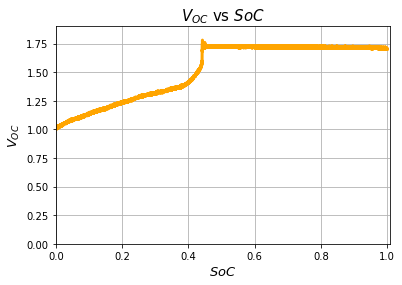

In [88]:
values = pd.read_csv("V_oc&SoC.csv")
plt.plot((values["SoC"]+0.8041270)/1.8041270, values["Voc"], color='orange', linewidth=3)
plt.xlabel("$SoC$", fontsize=13)
plt.ylabel("$V_{OC}$", fontsize=13)
plt.ylim(0, 1.9)
plt.xlim(-0.001, 1.01)
plt.grid(True)
plt.title("$V_{OC}$ vs $SoC$", fontsize=15)
plt.savefig('V_oc-vs-SoC.png')

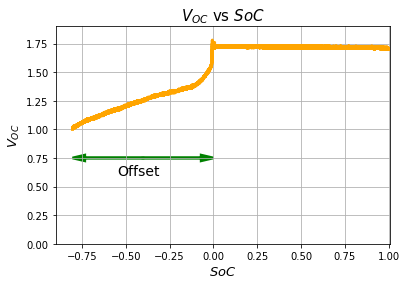

In [87]:
values = pd.read_csv("V_oc&SoC.csv")
plt.plot(values["SoC"], values["Voc"], color='orange', linewidth=3)
plt.xlabel("$SoC$", fontsize=13)
plt.ylabel("$V_{OC}$", fontsize=13)
plt.ylim(0, 1.9)
plt.xlim(-0.9, 1.01)
plt.grid(True)
plt.title("$V_{OC}$ vs $SoC$", fontsize=15)
plt.arrow(-0.402, 0.75, 0.402, 0, head_width=0.05, head_length=0.07, linewidth=2.7, color='g', length_includes_head=True)
plt.arrow(-0.402, 0.75, -0.402, 0, head_width=0.05, head_length=0.07, linewidth=2.7, color='g', length_includes_head=True)
plt.text(-0.55, 0.6, 'Offset', size=14)
plt.savefig('V_oc-vs-SoC_offeset.png')

***
## 📉 Phase 3 - Data Fitting
>  Fits curve to the generated plot for further SoC estimation using open circuit voltage measurement

##### Fitting equation based on 
##### $$V_{OC}(SoC) = K_0-K_{1}/SoC-K_{2}SoC+K_{3}ln(SoC)+K_{4}ln(1-SoC)$$
pg. 7 of yu, Zhihao & Huai, Ruituo & Xiao, Linjing. (2015). 
    "[State-of-Charge Estimation for Lithium-Ion Batteries 
    Using a Kalman Filter Based on Local Linearization](https://www.researchgate.net/publication/282462924_State-of-Charge_Estimation_for_Lithium-Ion_Batteries_Using_a_Kalman_Filter_Based_on_Local_Linearization)".



In [89]:
def guess_function(x, K0, K1, K2, K3, K4) :
    return (K0-(K1/x)-(K2*x)+(K3*np.log(x))+(K4*np.log(x)))

In [108]:
popt, pcov = curve_fit(guess_function, (values["SoC"]+0.8141270)/1.8041270, values["Voc"], p0=(2, 0.02, 5.2874, -2700.40315, 1400.91685), maxfev=10000)

In [110]:
param_file = open("Relation_param.csv", "a")
param_file.write(str(popt[0])+","+str(popt[1])+","+str(popt[2])+","+str(popt[3])+","+str(popt[4]))
param_file.close()

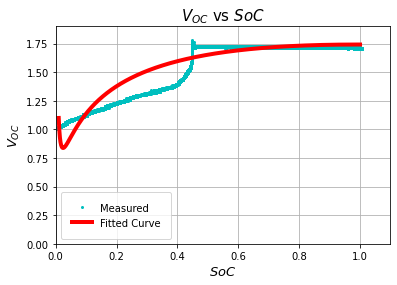

In [111]:
t= np.linspace(0.01001, 1, 2000)
plt.plot((values["SoC"]+0.8141270)/1.8041270, values["Voc"], 'co', markersize=2)
plt.ylim(0, 1.9)
plt.xlim(0, 1.1)
plt.xlabel("$SoC$", fontsize=13)
plt.ylabel("$V_{OC}$", fontsize=13)
plt.title("$V_{OC}$ vs $SoC$", fontsize=15)
plt.grid(True)
plt.plot(t, guess_function(t, popt[0], popt[1], popt[2], popt[3], popt[4]),'r-', linewidth = 4)
plt.legend(['Measured', 'Fitted Curve'], borderpad=1.1)
plt.savefig('V_oc-vs-SoC-fitted.png')
plt.show()

#### We get the curve fitting parameters as follows

$$\theta = \begin{bmatrix} K_0 \\ K_1 \\ K_2 \\ K_3 \\ K_4 \end{bmatrix}=\begin{bmatrix}  2.22221763 \\ -0.0119085674 \\ 0.492858021 \\ 13186.4572 \\  -13185.9561 \end{bmatrix}$$
##### Covariance for the fitting 

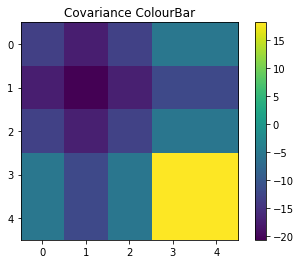

In [113]:
pcov
plt.imshow(np.log(np.abs(pcov)))
plt.colorbar()
plt.title('Covariance ColourBar')
plt.savefig('Relation-param-cov-cbar.png')
plt.show()

In [114]:
popt

array([ 2.22221763e+00, -1.19085674e-02,  4.92858021e-01,  1.31864572e+04,
       -1.31859561e+04])

***
## <center> 🔋Notebook Concludes 📖

***
## Prasanna Paithankar
### Department of Electrical Engineering, Indian Institute of Technology, Kharagpur

##### Submitted to Autonomous Ground Vehical Research Group, IIT Kharagpur

<img src="AGVlogo.png" class="bg-primary" width="200px">